# Bayesian Deep Learning
http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

In [2]:
%matplotlib inline
import pymc3 as pm
import theano
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

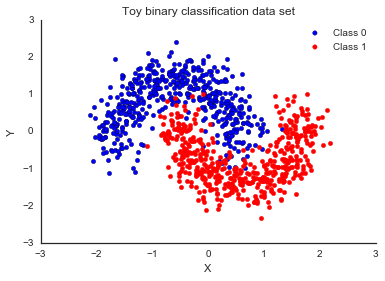

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [6]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

In [8]:
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                             shape=(X.shape[1], n_hidden), testval=init_1)
    
    # Weights from 1st layer to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                             shape=(n_hidden, n_hidden), testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                             shape=(n_hidden,), testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    # Binary classfication -> Bernoulli likelihood
    out = pm.Bernoulli('out', act_out, observed=ann_output)

In [9]:
%%time

with neural_network:
    '''
    Run ADVI which returns posterior means, standard deviations,
    and the evidence lower bound(ELBO)
    '''
    v_params = pm.variational.advi(n=50000)

Iteration 0 [0%]: ELBO = -326.44
Iteration 5000 [10%]: Average ELBO = -329.87
Iteration 10000 [20%]: Average ELBO = -250.82
Iteration 15000 [30%]: Average ELBO = -224.37
Iteration 20000 [40%]: Average ELBO = -211.63
Iteration 25000 [50%]: Average ELBO = -197.33
Iteration 30000 [60%]: Average ELBO = -172.53
Iteration 35000 [70%]: Average ELBO = -146.58
Iteration 40000 [80%]: Average ELBO = -135.36
Iteration 45000 [90%]: Average ELBO = -130.41
Finished [100%]: Average ELBO = -128.78
CPU times: user 19.9 s, sys: 1.07 s, total: 21 s
Wall time: 1min 24s


In [10]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

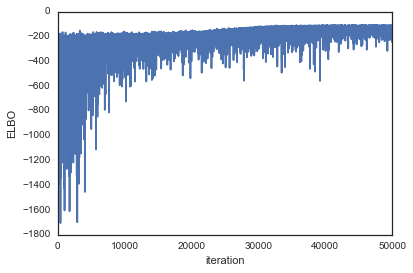

In [11]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [12]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

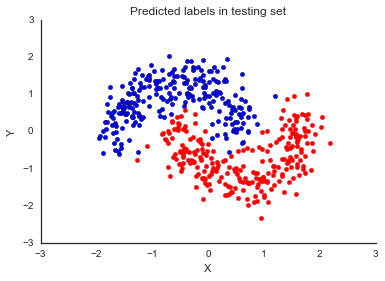

In [14]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [15]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 96.0%
